In [46]:
import numpy as np
import pandas as pd
from sklearn import linear_model, preprocessing
from sklearnex import patch_sklearn
patch_sklearn()
from patsy import dmatrices, dmatrix
import copy
import re
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


use one hot encoded data

In [47]:
train = pd.read_csv('C:/Users/Chris Li/Documents/UC Davis/STA 208/Data/train_one_hot.csv').drop(columns = ['Unnamed: 0'])
test = pd.read_csv('C:/Users/Chris Li/Documents/UC Davis/STA 208/Data/test_one_hot.csv').drop(columns = ['Unnamed: 0'])

In [48]:

train_x = train.drop(columns = ['y']).to_numpy()

train_y = train['y'].to_numpy()
train_y = np.where(train_y == 'no', 0, 1)

test_x = test.drop(columns = ['y']).to_numpy()

test_y = test['y'].to_numpy()
test_y = np.where(test_y == 'no', 0, 1)



### Conduct Cross Validation to Tune Max Tree Depth

In [62]:

from sklearn.model_selection import train_test_split
loop_list = []
auc_list = []
rng = range(2,30)
for i in rng:
    print(i)
    rf_loop = RandomForestClassifier(max_depth=i, random_state = 0, n_estimators=50, max_features="sqrt", criterion = "entropy",
                           max_samples = None)
    x_train,x_test, y_train, y_test = train_test_split(train_x,train_y, test_size = 0.2, train_size = 0.8, random_state = 22)
    rf_loop.fit(x_train, y_train)
    test_pred_prob_loop = rf_loop.predict_proba(x_test)
    # second column is probability of getting 1, yes
    test_pred_prob_loop  = test_pred_prob_loop [:,1]
    fpr_loop, tpr_loop, thresh_loop = roc_curve(y_test,test_pred_prob_loop)
    loop_list.append([fpr_loop, tpr_loop, thresh_loop])
    
    auc_loop = auc(fpr_loop,tpr_loop)
    auc_list.append(auc_loop)
    

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Text(0, 0.5, 'AUC')

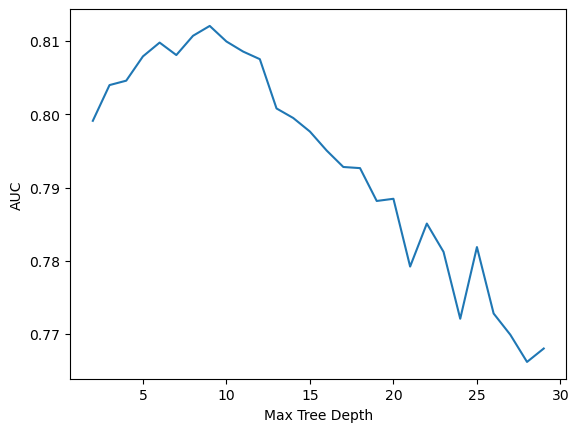

In [63]:
auc_arr = np.array(auc_list)
plt.plot(rng,auc_arr)
plt.xlabel('Max Tree Depth')
plt.ylabel('AUC')

In [64]:
rng[np.argmax(np.array(auc_list))]

9

Choose max depth 9 to prevent overfitting

In [67]:
# use 50 trees
rf = RandomForestClassifier(max_depth=rng[np.argmax(np.array(auc_list))], random_state = 0, n_estimators=50, max_features="sqrt", criterion = "entropy",
                           max_samples = None)

In [68]:
rf.fit(train_x, train_y)

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=50,
                       random_state=0)

In [69]:
test_pred = rf.predict(test_x)
test_pred_prob = rf.predict_proba(test_x)

# second column is probability of getting 1, yes
test_pred_prob = test_pred_prob[:,1]

In [70]:
con = confusion_matrix(test_y,test_pred)
conf_matrix = confusion_matrix(test_y,test_pred)
conf_matrix

array([[7184,  102],
       [ 747,  205]], dtype=int64)

In [71]:
print("Accuracy")
print((con[1,1] + con[0,0])/(np.sum(con)))

Accuracy
0.8969410050983249


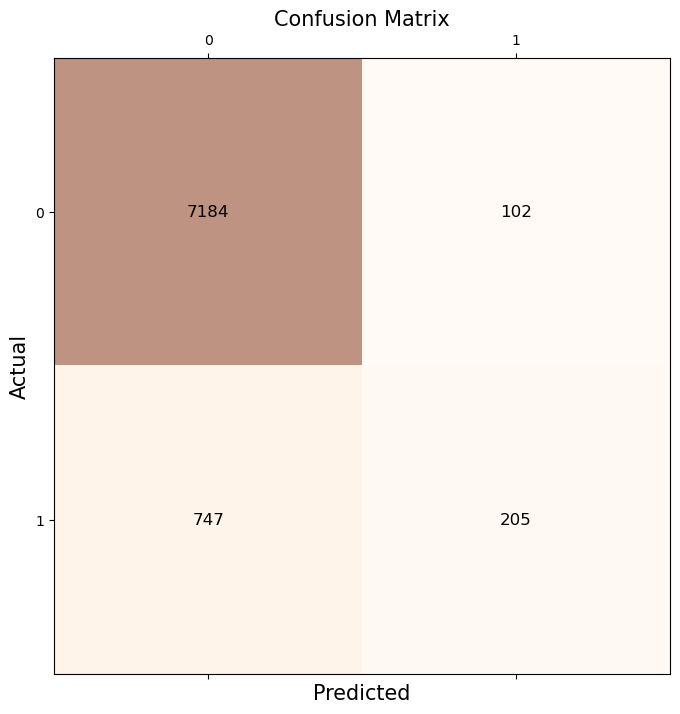

In [72]:
# plot confusion matrix
fig, axes = plt.subplots(figsize=(8, 8))
axes.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        axes.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actual', fontsize=15)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [76]:
print("TPR")
print(con[1,1]/(con[1,0]+con[1,1]))
print("FPR")
print(con[0,1]/(con[0,0]+con[0,1]))
print("TNR")
print(con[0,0]/(con[0,0]+con[0,1]))
print("FNR")
print(con[1,0]/(con[1,0]+con[1,1]))
print("precision")
print(con[1,1]/(con[0,1]+con[1,1]))
print("f1score")
print((2*con[1,1])/(2*con[1,1] + con[0,1] + con[1,0]))

TPR
0.21533613445378152
FPR
0.013999451001921494
TNR
0.9860005489980785
FNR
0.7846638655462185
precision
0.6677524429967426
f1score
0.3256552819698173


### ROC curves

Text(0.5, 1.0, 'ROC Curve\nAUC = 0.804')

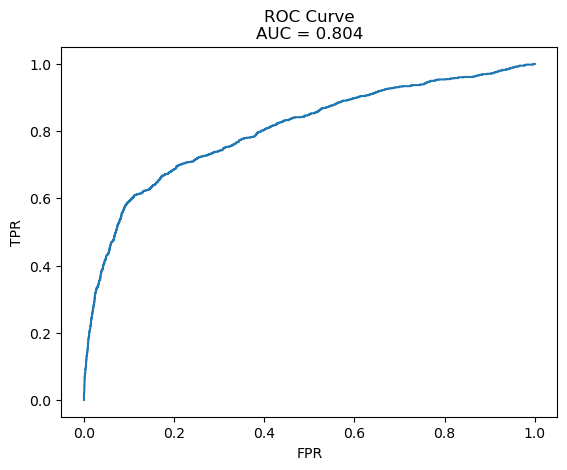

In [74]:
fpr, tpr, thresh = roc_curve(test_y,test_pred_prob)

plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
auc_calc = auc(fpr,tpr)
plt.title("ROC Curve\nAUC = " + str(round(auc_calc,3)))


Now try getting threshold so that TPR and TNR are close together

In [77]:
# choose optimal threshold that brings TPR and TNR as close together
tnr = 1-fpr
tnr_tpr_diff = abs(tnr-tpr)
opt2_index = np.argmin(tnr_tpr_diff)
opt2_threshold = thresh[opt2_index]
opt2_threshold

0.06861712649311066

In [78]:
# corresponding conf matrix
opt2_thres_pred = np.where(test_pred_prob <= opt2_threshold, 0, 1)
con_opt2=confusion_matrix(test_y,opt2_thres_pred)
con_opt2

array([[5306, 1980],
       [ 260,  692]], dtype=int64)

In [79]:
print("TPR")
print(con_opt2[1,1]/(con_opt2[1,0]+con_opt2[1,1]))
print("FPR")
print(con_opt2[0,1]/(con_opt2[0,0]+con_opt2[0,1]))
print("TNR")
print(con_opt2[0,0]/(con_opt2[0,0]+con_opt2[0,1]))
print("FNR")
print(con_opt2[1,0]/(con_opt2[1,0]+con_opt2[1,1]))

TPR
0.726890756302521
FPR
0.271754048860829
TNR
0.728245951139171
FNR
0.27310924369747897


In [80]:
print("Accuracy")
print((con_opt2[1,1] + con_opt2[0,0])/(np.sum(con_opt2)))


Accuracy
0.7280893420733188


### Feature Importance - MDI

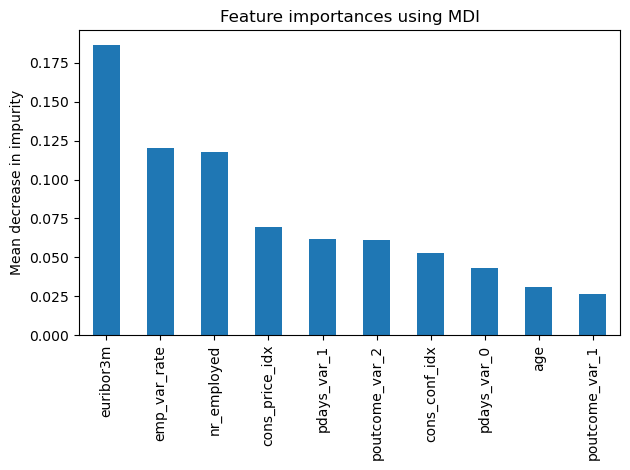

In [81]:
importances = rf.feature_importances_

feature_names = train.drop(columns = ['y']).columns.to_list()

forest_importances = pd.DataFrame(pd.Series(importances, index=feature_names))
forest_importances.columns = ['importances']

forest_importances = forest_importances.sort_values(by = 'importances', ascending = False)


# filter to only 10 most important variables when plotting
fig, ax = plt.subplots()
forest_importances.head(10).plot.bar(ax=ax, legend = None)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()